In [1]:
%load_ext autoreload
%autoreload 2
%aimport peaks

# Basic data operations
[Standard xarray calls](https://docs.xarray.dev/en/stable/user-guide/indexing.html) can be used for indexing, selecting from, and manipulating the DataArray. 

In [2]:
# Import packages
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import peaks as pks
import os

# Set default options
xr.set_options(cmap_sequential='Purples', keep_attrs=True)
%matplotlib inline
%config InlineBackend.figure_format='retina'

# Get ureg for pints units
import pint_xarray
ureg = pint_xarray.unit_registry
import pint

# File path of the example data
fpath = os.getenv('PEAKS_EXAMPLE_DATA_PATH')
pks.opts.FileIO.path = os.path.join(fpath,'i05-59')
pks.opts.FileIO.ext = 'nxs'

# Load some data
disp1 = pks.load(819)
dt = pks.load([819,853], names=['disp1','gold'])

Loading data:   0%|          | 0/2 [00:00<?, ?it/s]

For example, to subtract a constant from a :class:`xarray.DataArray`, simple arithmetic operations can be used. However, be careful to treat units properly using :class:`pint`

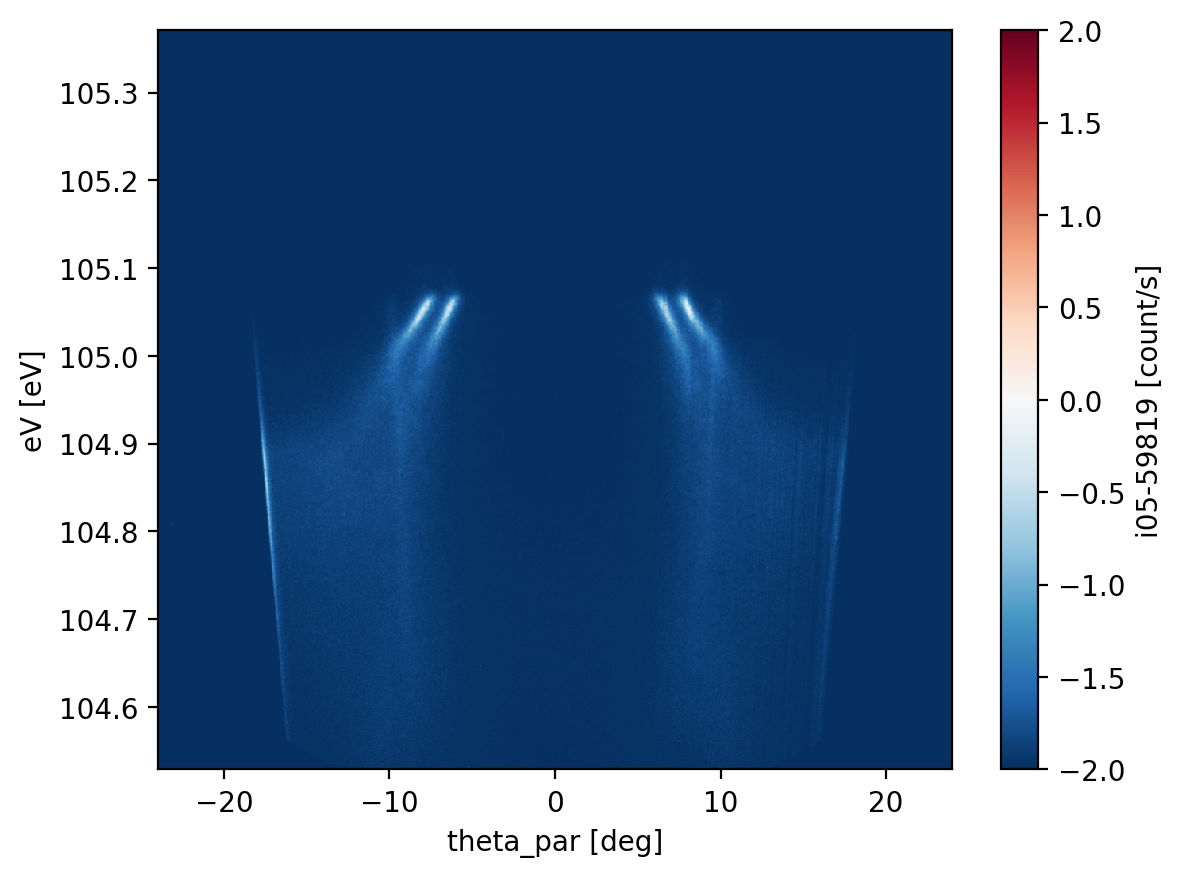

In [3]:
(disp1-(2*ureg('count/s'))).plot()

:::{admonition} Summing data
:class: warning
While you can sum two DataArrays together using simple arithmetic operations, often the underlying :class:`xarray.DataArray`s may have small numerical differences in the relevant scales, and will have different metadata. To sum two or more scans together, use `pks.sum_data(data_to_sum)` where `data_to_sum` is a list of the scans to sum together. They will be interpolated onto exactly the same data grid, although you should only pass :class:`xarray.DataArray`s which are already measured on nominally the same grid.
:::

Data can be selected using `.sel` and averaged using `.mean`:

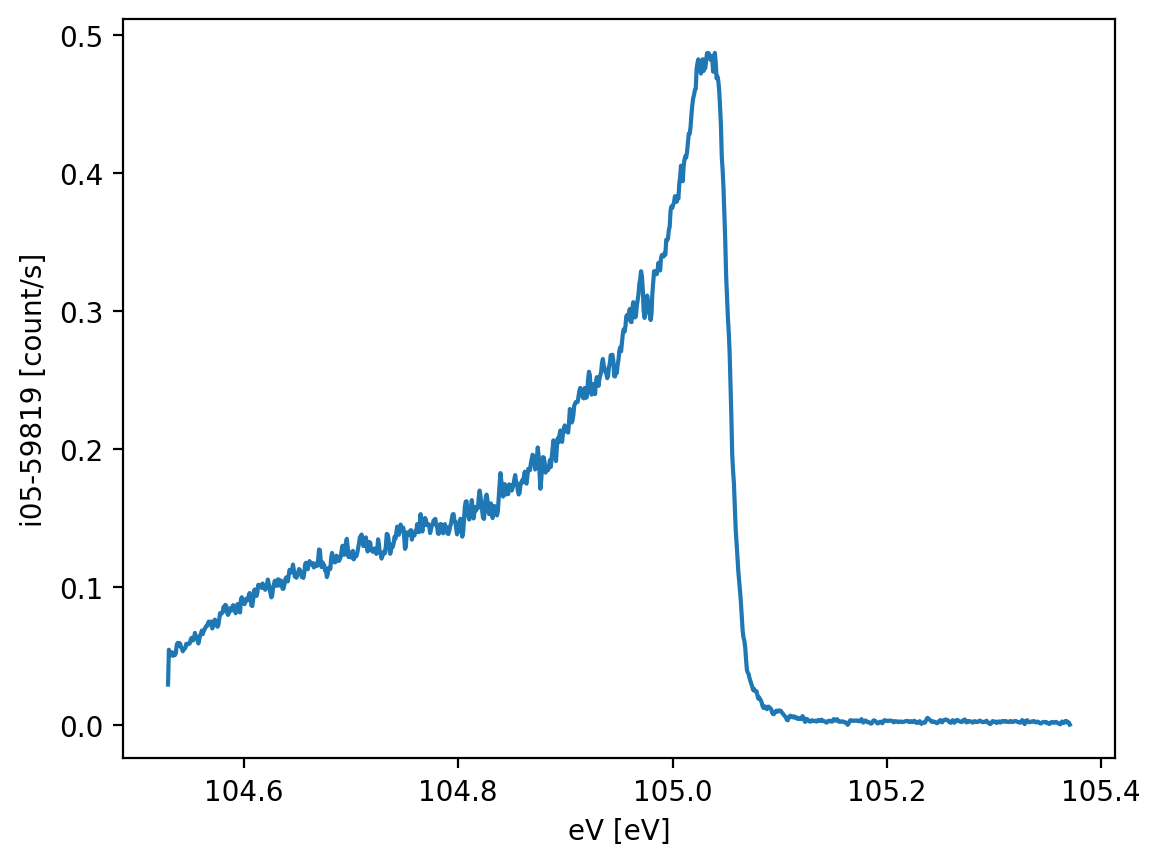

In [4]:
disp1.sel(theta_par=slice(-10,-8)).mean('theta_par').plot()

It is also possible to select with [unit-full indexing](https://xarray.dev/blog/introducing-pint-xarray) using `pint-xarray`, passing the units as either `pint.Unit`s or via the `pint_xarray` unit-registry: `ureg=pint_xarray.unit_registry`

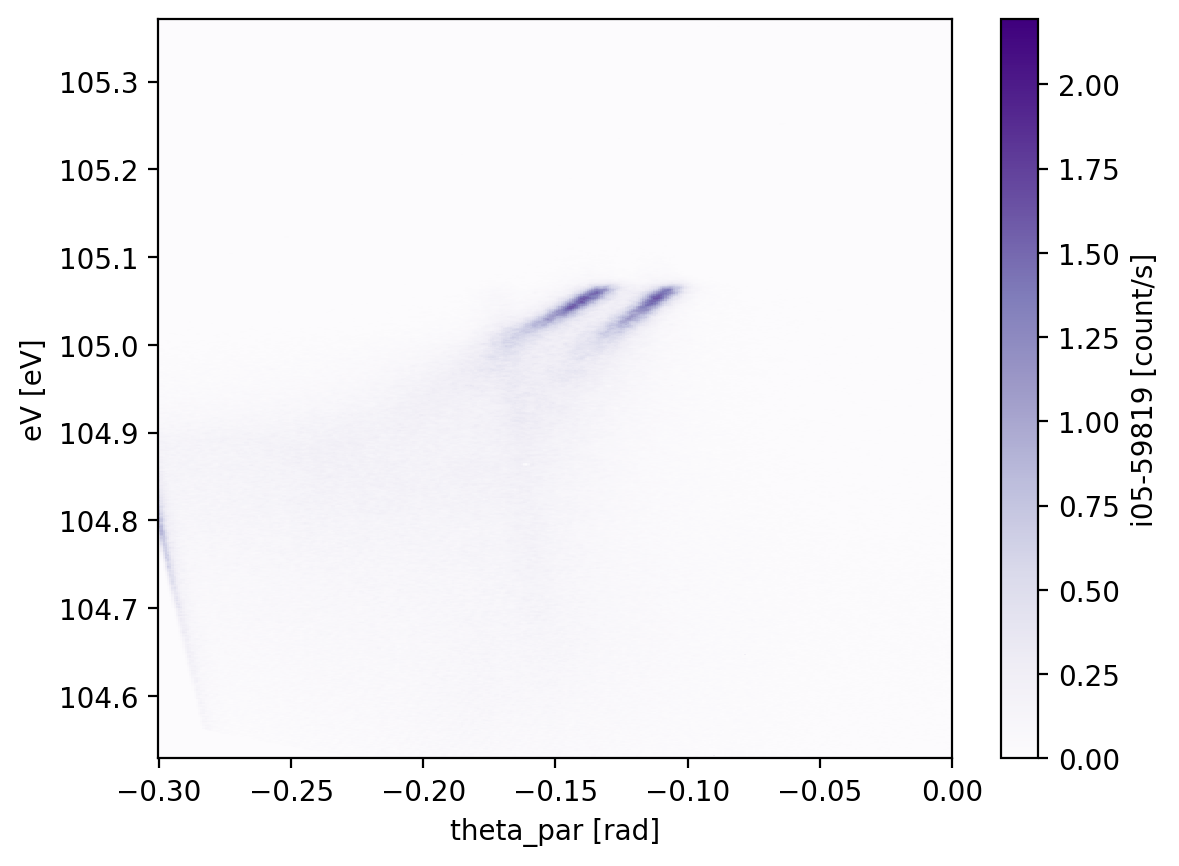

In [5]:
disp1.pint.sel(theta_par=slice(-0.3*pint.Unit('radians'),0)).plot()

:::{tip}Broadcasting across DataTrees
Many of the in-built :class:`xarray.DataArray` methods, as well a significant number of the `peaks` data selection and processing functions will broadcast when applied to a :class:`xarray.DataTree`, returning another :class:`xarray.DataTree` with the relevant function applied. This can be useful for batch processing of data. Some examples are given below.
:::

### EDC and MDC extraction
Helper functions exist for quick extraction of one or an array of EDCs and MDCs, including optional integration. These can be applied directly to :class:`xarray.DataArrays`

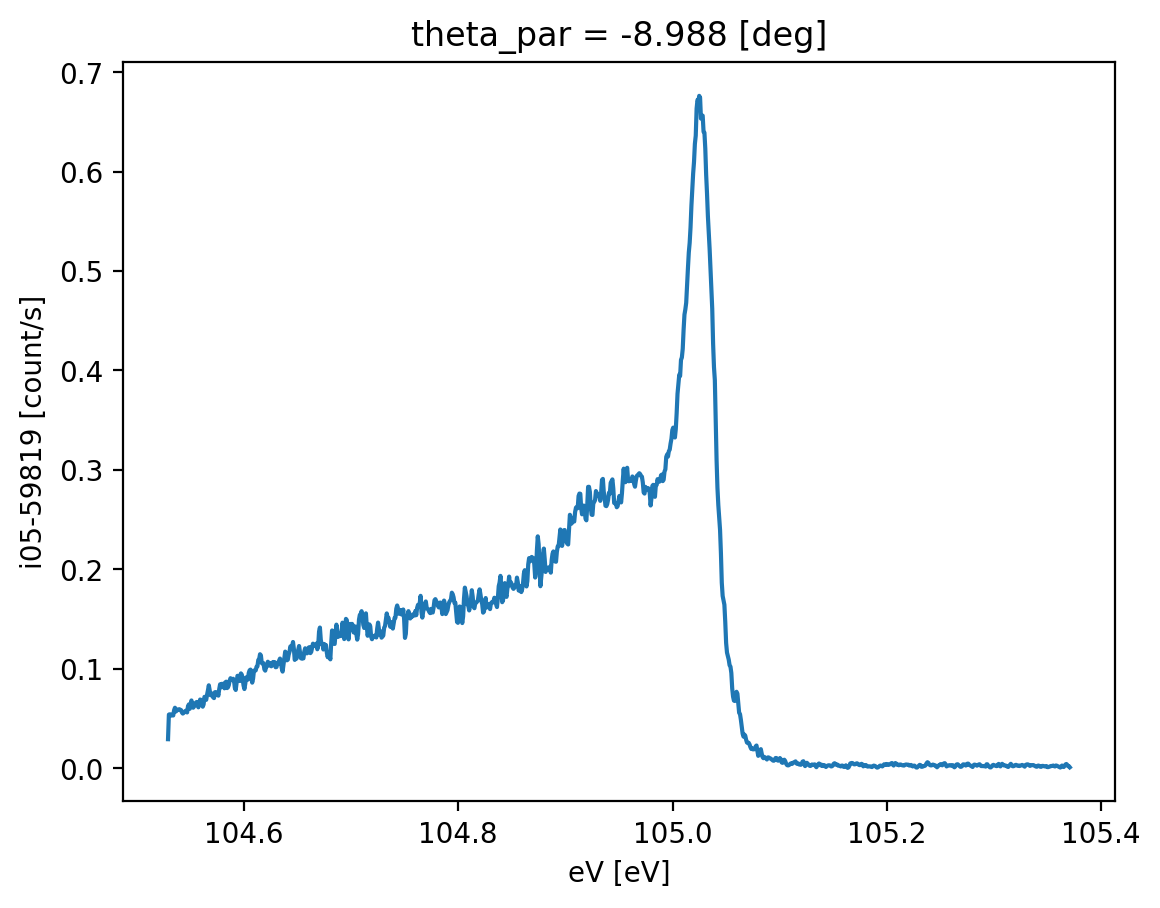

In [6]:
disp1.EDC(-9, 1).plot()

Or can be applied to a :class:`xarray.DataTree` to return a new :class:`xarray.DataTree` with the same DC extracted from each scan 

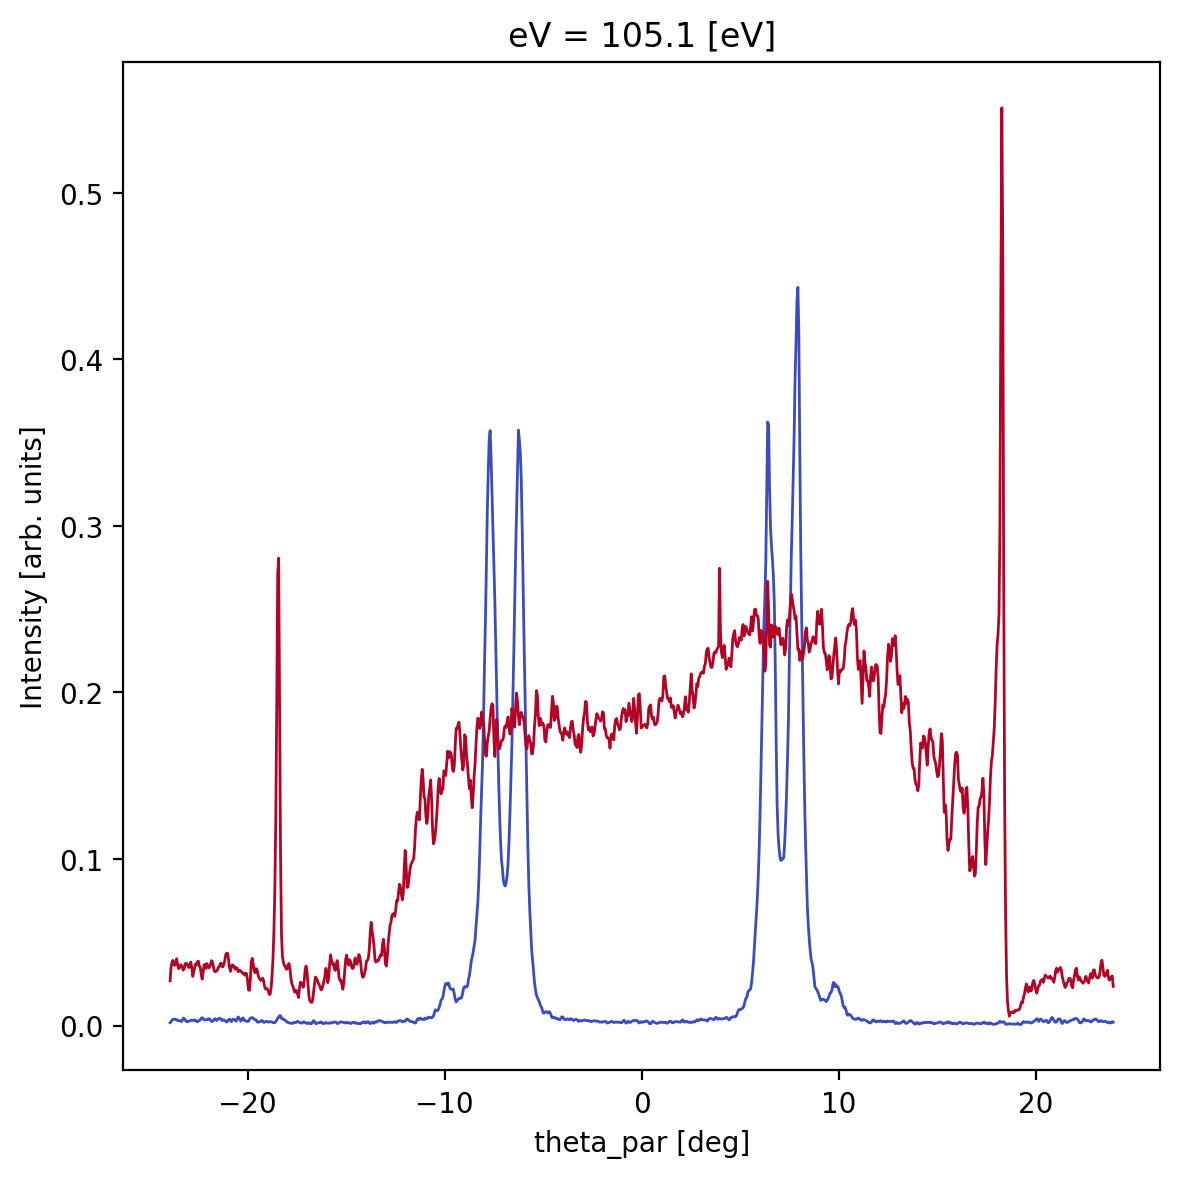

In [7]:
dt.MDC(105.08,0.05).plot_DCs(x='theta_par')

Multiple DCs can be extracted from a single scan

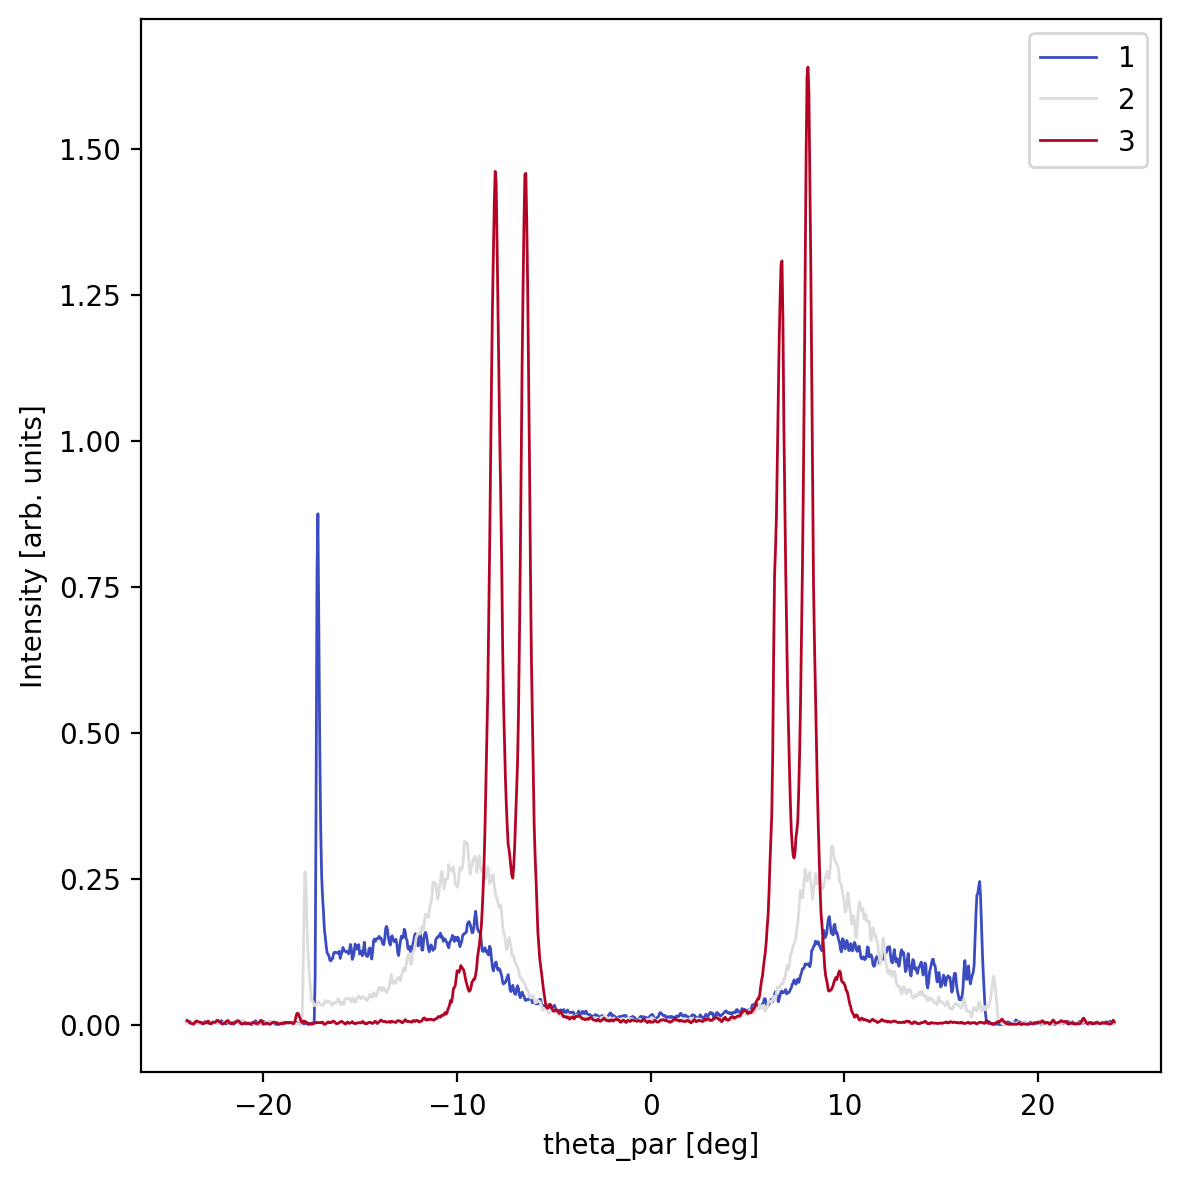

In [8]:
MDCs = disp1.MDC([104.8,104.95,105.05],0.01)
pks.plot_DCs(MDCs, titles=['1','2','3'])  # Plot the extracted DCs

The DC-type methods can be applied to higher-dimensional data, e.g. to extract a Fermi surface:

[########################################] | 100% Completed | 5.26 s


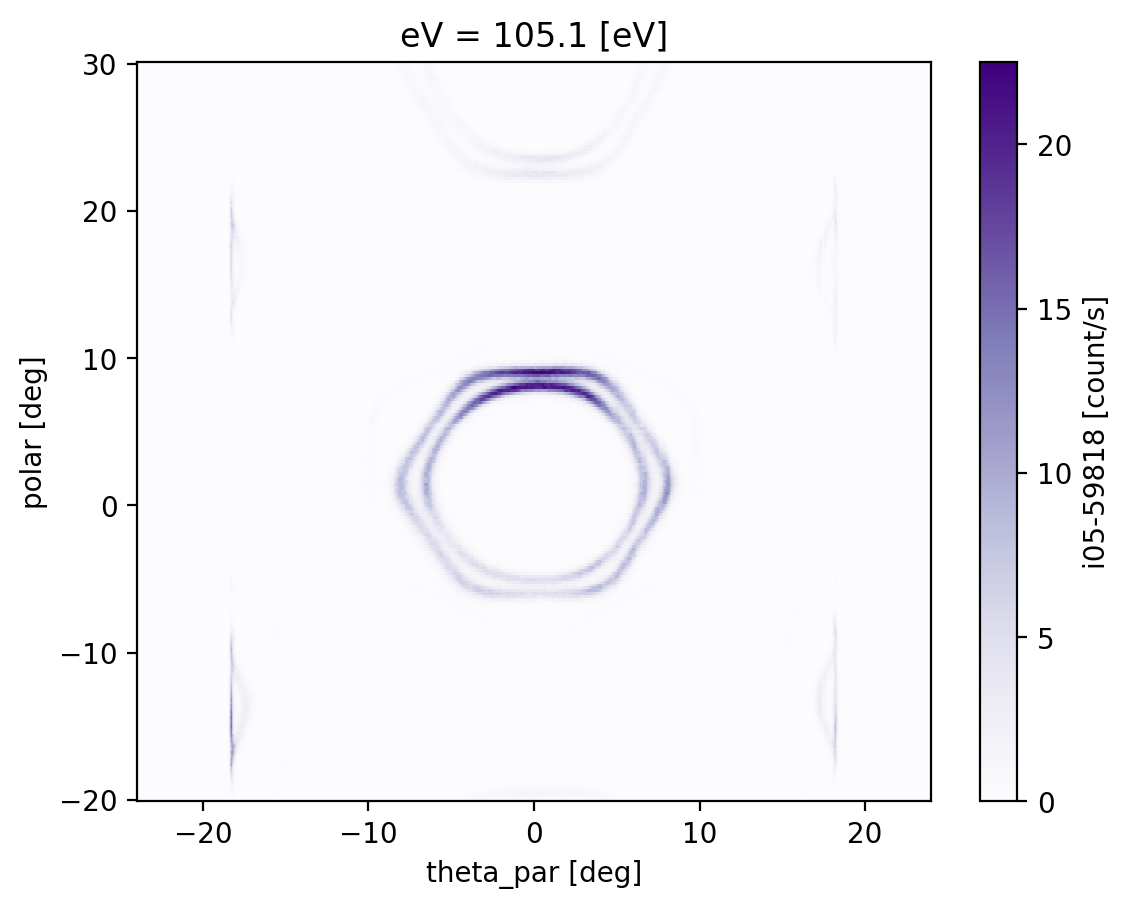

In [9]:
FS1 = pks.load(818)
FS1.MDC(105.05,0.02).plot()

:::{tip}
The function `.DC` is the underlying function called by the `MDC` and `EDC` methods. This can be called directly, allowing EDC and MDC-like functionality to be applied to extract a slice along any dimension from a :class:`xarray.DataArray` with arbitrary dimensions.
:::

### Extracting arbitrary cuts
For extraction of a single cut between a single start and end point (MDCs, dispersions, or in principle any slice of an arbitrary dimensional array between start and end points defined in two dimensions), the `.extract_cut` method can be used.

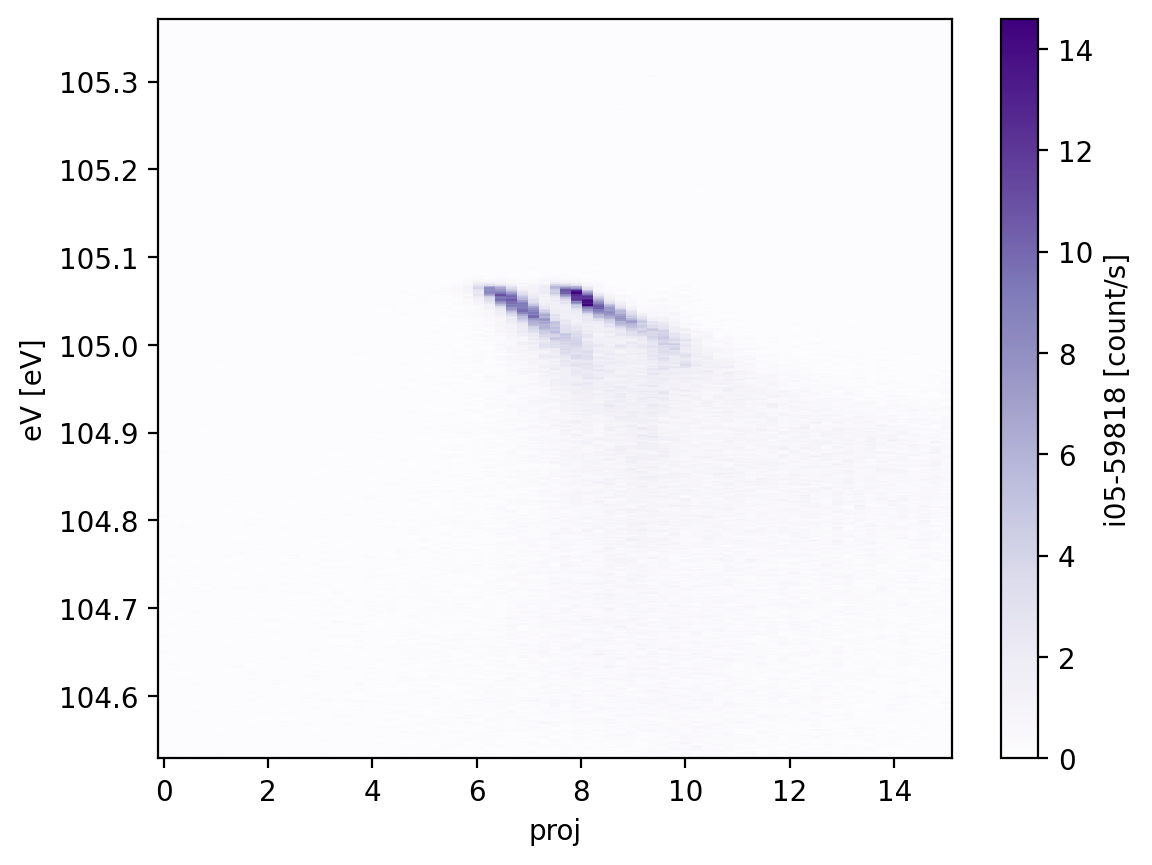

In [10]:
# Extract a dispersion from a FS data cube
cut = FS1.extract_cut(start_point={'theta_par':0, 'polar': 1.5},
                          end_point={'theta_par':15, 'polar': 1.5})
cut.plot()

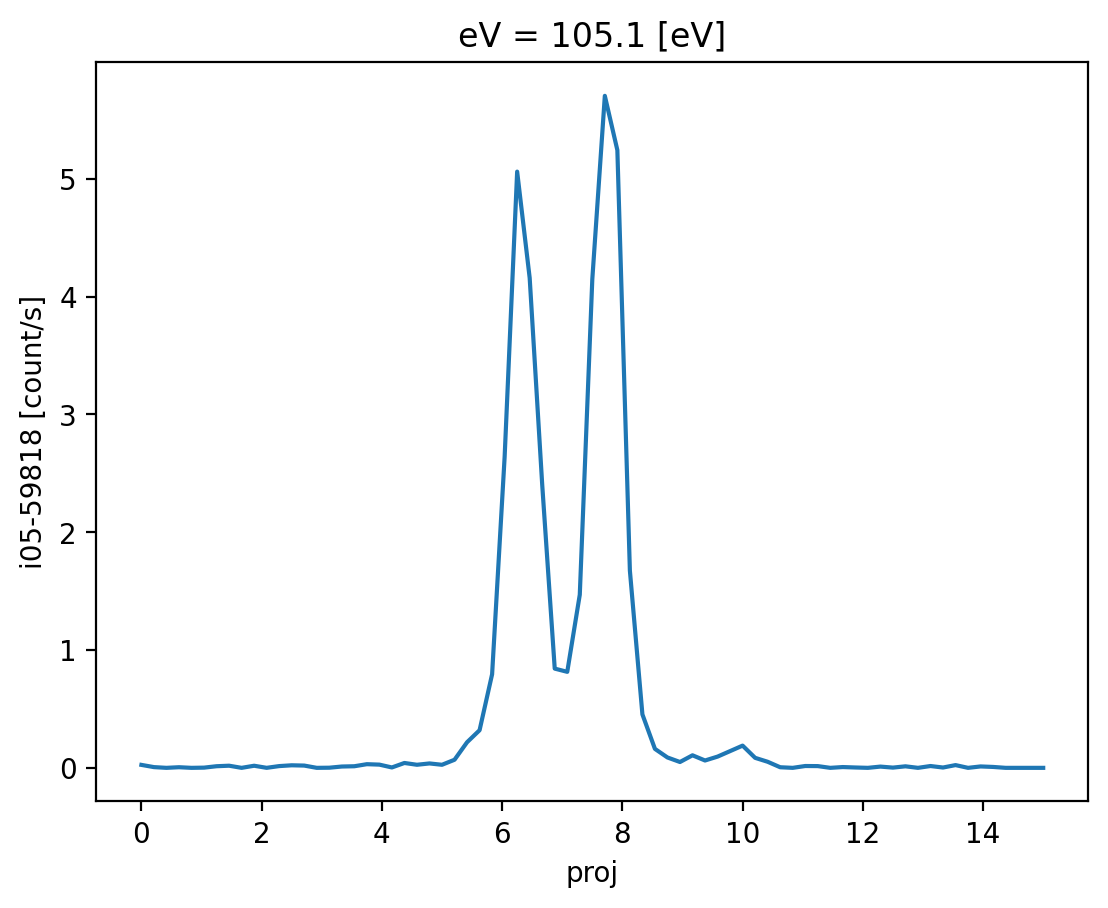

In [11]:
# Extract an arbitrary cut from an energy slice
FSM = FS1.MDC(105.067, 0.01)
# Extract the MDC between the same start and end points as above
FSM.extract_cut(start_point={'theta_par':0, 'polar': 1.5},
                          end_point={'theta_par':15, 'polar': 1.5}).plot()

### Radial cuts
A special helper function, `.radial_cuts`, exists to take a series of these cuts as radial cuts of some radius around a single point

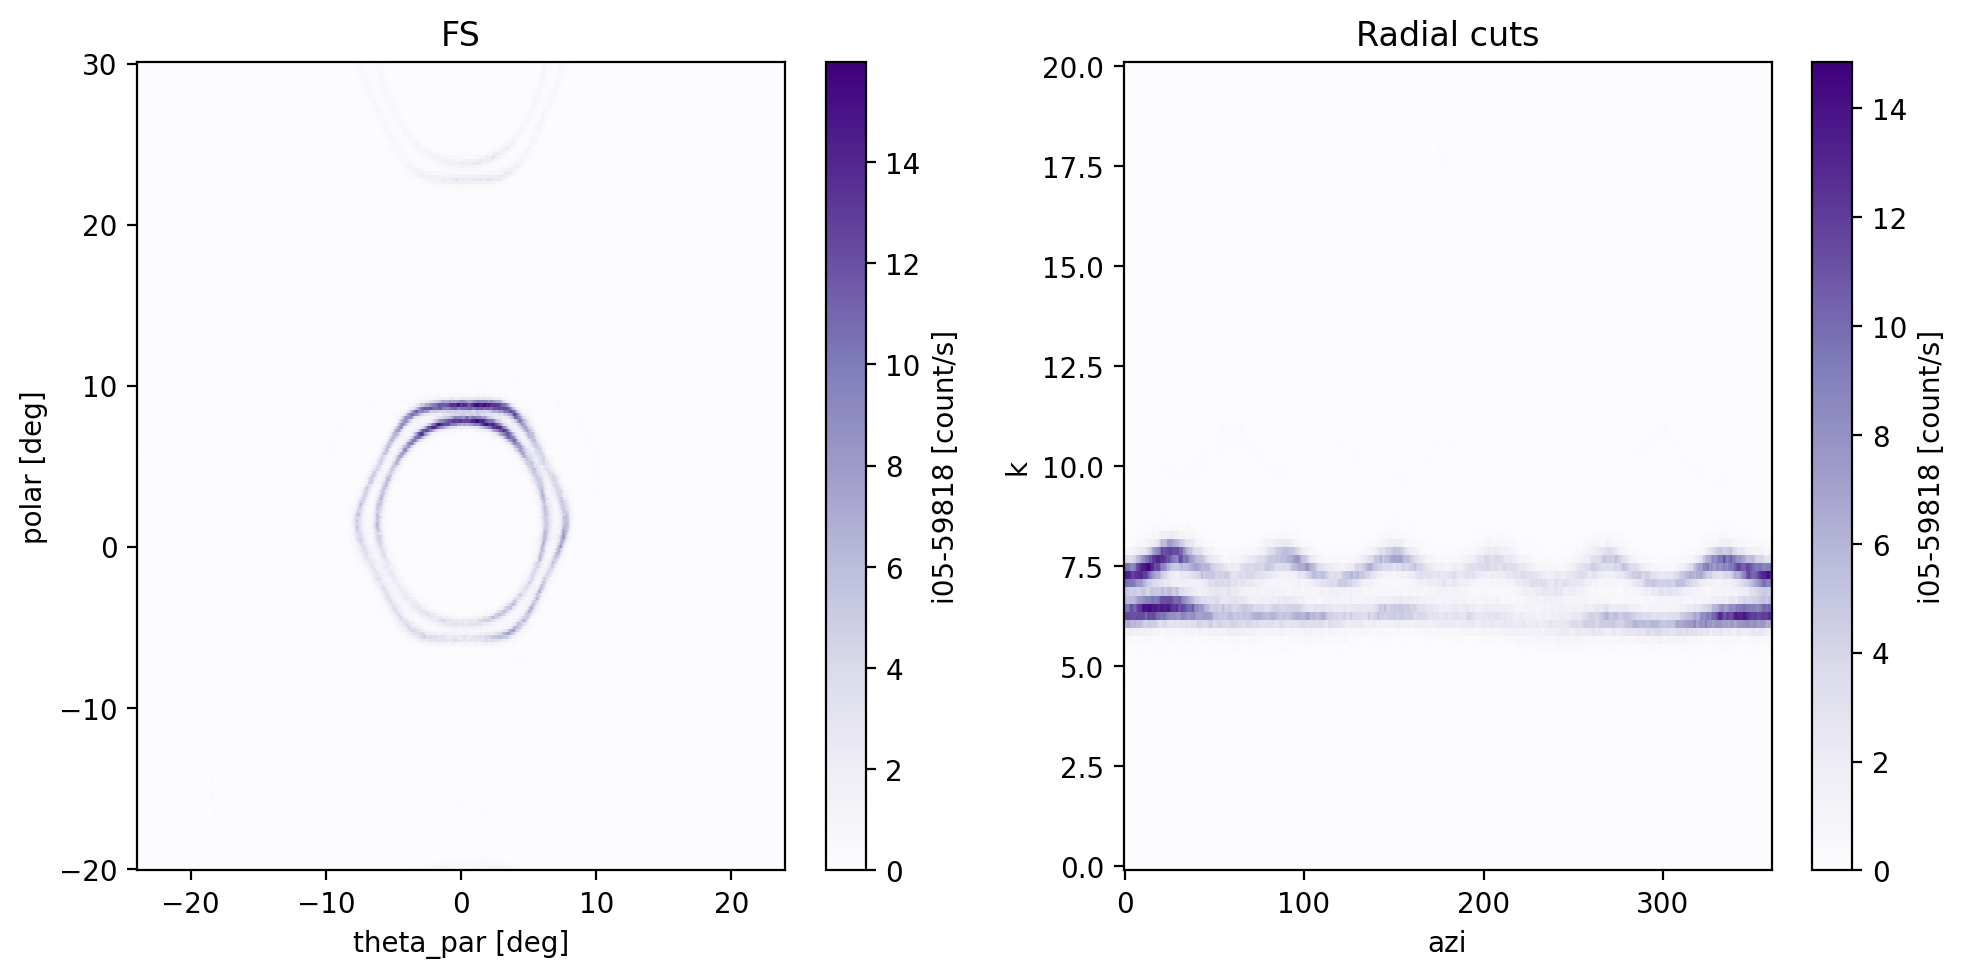

In [12]:
cuts = FSM.radial_cuts(radius=20,  # radius of the cuts
                       polar=1.5,  # centre co-ordinates
                       num_points=100)
pks.plot_grid([FSM,cuts],
             titles=["FS","Radial cuts"])

The `.radial_cuts` can be used on any :class:`xrray.DataArray` which has two angle or momentum directions (which are assumed to have the same units). If an energy dimension is also present, the interpolation will be broadcast over the energy dimension.

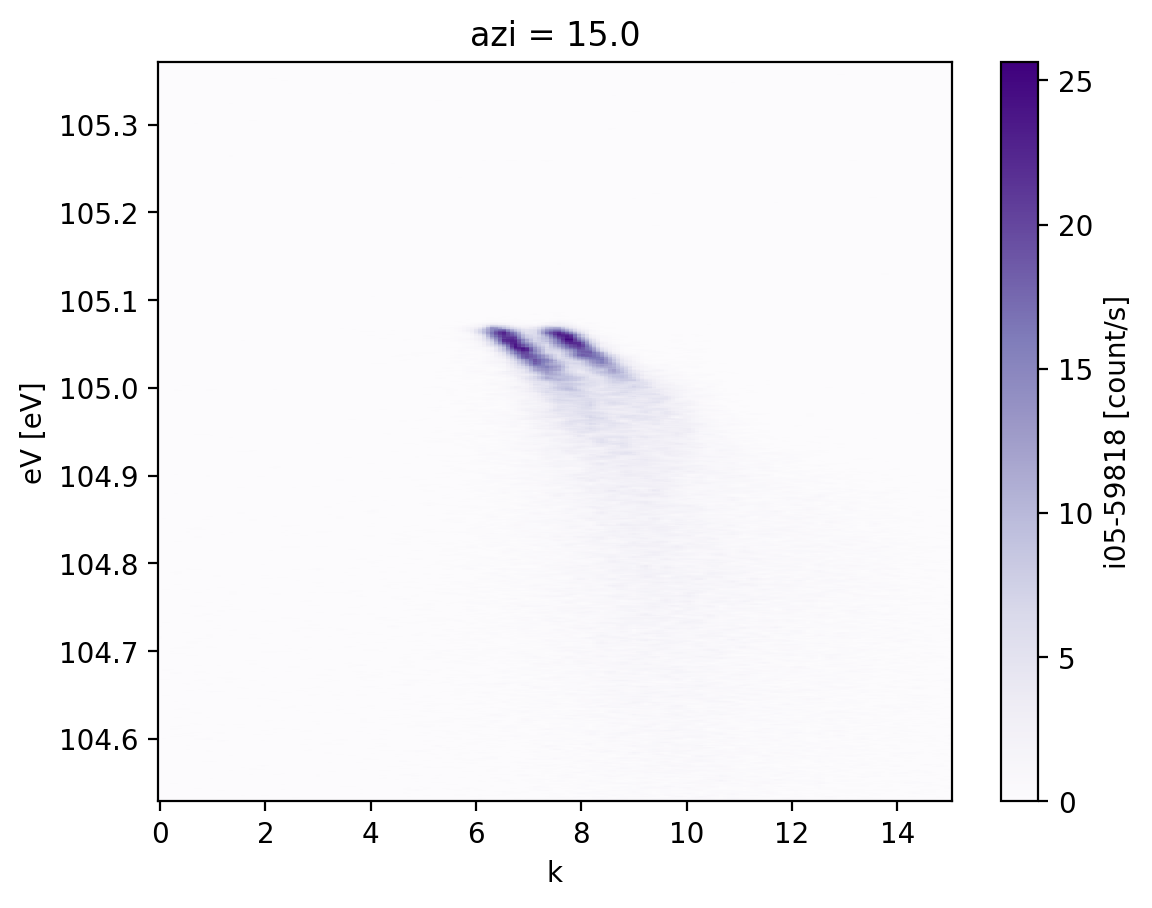

In [13]:
# Now passing the full 3D array
ang_slices = FS1.radial_cuts(radius=15,  # radius of the cuts
                       polar=1.5,  # centre co-ordinates
                       num_points=201)

# Select a single azimuth value to plot
ang_slices.isel(azi=15).plot()

:::{note}
In principle, these function will accept :class:`xarray.DataArray`'s backed by :class:`dask.array.core.Array` arrays. This appears to work for the `.extract_cut` function above, however, appears unstable at present for `.radial_cuts` and requires further testing. In case of problems, it is currently recommended to run `.compute()` before passing to the `.radial_cuts` function.
:::